# DTSA 5798 Final Project

## Project Introduction

Imagine you're working at a media buying company, Chrishare. They have a new client, Theragun. Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using the k-train, which is a wrapper for
Tensorflow, Keras, and Huggingface Transformers.

* Project Workflow
  * Data Collection and Preprocessing
  * Training Model
  * Model Evaluation
  * Conclusion

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Collection and Preprocessing

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns

# Monkey patch to restore np.Inf for broken packages
if not hasattr(np, 'Inf'):
    np.Inf = np.inf

In [7]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### Data Exploration - Exploring Categories

I counted the articles by the corresponding categories, and the most common category is **POLITICS**.

For this project, I am going to build AI that detects whether a web page mentions **health** and **wellness** news content.

In [8]:
reviews.groupby('category',as_index = False)['headline'].count().sort_values('headline', ascending = False)

,category,headline
24,POLITICS,32739
37,WELLNESS,17827
10,ENTERTAINMENT,16058
34,TRAVEL,9887
30,STYLE & BEAUTY,9649
22,PARENTING,8677
16,HEALTHY LIVING,6694
25,QUEER VOICES,6314
13,FOOD & DRINK,6226
3,BUSINESS,5937


We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

### Preparing the Data

In [9]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living or wellness?" column. That is, when an article is about healthy living or wellness, it should have a 1, when it's anything else, it should be a 0.

In [10]:
reviews['health_and_wellness'] = np.where((reviews['category'] == 'HEALTHY LIVING') | (reviews['category'] == 'WELLNESS'), 1, 0)

In [11]:
reviews[reviews['health_and_wellness'] == 1].head()

,category,headline,authors,link,short_description,date,combined_text,health_and_wellness
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...,1
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1


In [12]:
reviews['health_and_wellness'].describe()

,health_and_wellness
count,200853.000000
mean,0.122084
std,0.327384
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<Axes: xlabel='health_and_wellness', ylabel='Count'>

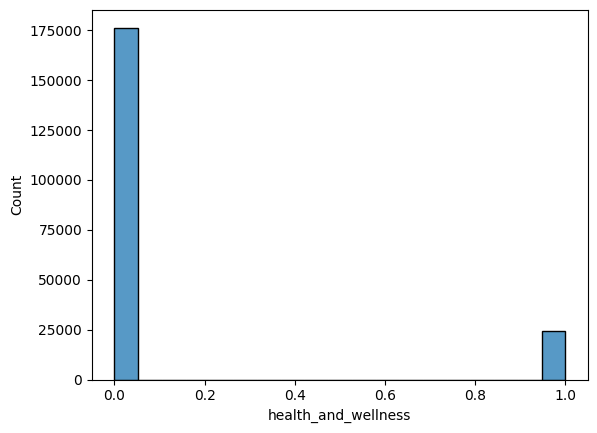

In [13]:
sns.histplot(reviews['health_and_wellness'])

Yes! We're seeing the 1's where we'd expect.

So our data is very unbalanced. We have 24,521 articles about healthly living and wellness, and about 176k that are not. If we give a machine learning algorithm this much negative evidence, it'll end up tuning itself to label everything as 0's more often than not. So, let's balance our data we have 24,521 articles that are healthy living or wellness, and 24,521 that are not!

In [14]:
sample_amount = 24521

healthy = reviews[reviews['health_and_wellness'] == 1]
not_healthy = reviews[reviews['health_and_wellness'] == 0].sample(n=sample_amount)

In [15]:
review_sample = pd.concat([healthy,not_healthy])

In [16]:
review_sample.describe()

,date,health_and_wellness
count,49042,49042.000000
mean,2014-08-08 14:05:29.741853696,0.500000
min,2012-01-28 00:00:00,0.000000
25%,2013-02-25 00:00:00,0.000000
50%,2014-03-12 00:00:00,0.500000
75%,2015-12-26 00:00:00,1.000000
max,2018-05-26 00:00:00,1.000000
std,NaN,0.500005


A mean of .5 means these datasets are now perfectly balanced! And the N = 2*24521.

## Training Model

Now that the dataset is preprocessed and balanced, we will use ktrain to train the model.

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)

In [2]:
ktrain.text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


DistilBERT: A lighter, faster version of BERT developed by Hugging Face, offering efficient performance with reduced computational cost.

In [17]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_and_wellness"],
    val_df=None,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
)

['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
49284                       1.0                  0.0
89884                       1.0                  0.0
121302                      1.0                  0.0
160998                      1.0                  0.0
94677                       1.0                  0.0
['not_health_and_wellness', 'health_and_wellness']
        not_health_and_wellness  health_and_wellness
129442                      0.0                  1.0
110272                      1.0                  0.0
184183                      0.0                  1.0
57364                       0.0                  1.0
133765                      0.0                  1.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 57
	99percentile : 67


In [18]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

Original codes from the lecture took `max_epochs=6`, but for this project, since the sample size got much bigger, `max_epochs=3` will do.

In [22]:
learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2758/2758 [==============================] - 1841s 659ms/step - loss: 0.4122 - accuracy: 0.8150
Epoch 2/3
2758/2758 [==============================] - 1816s 658ms/step - loss: 0.5563 - accuracy: 0.6399
Epoch 3/3
2758/2758 [==============================] - 451s 164ms/step - loss: 35.2476 - accuracy: 0.5016


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


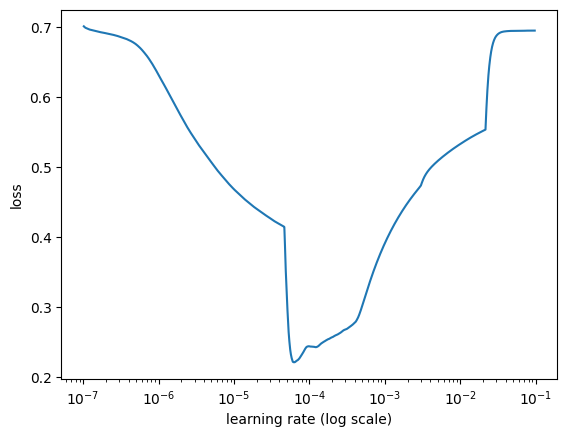

In [23]:
learner.lr_plot()

### Selecting the learning rate and Model Fitting

Let's get the most optimal learning rate.

* Based on the loss curve in the chart above, the optimal loss occurs between 10⁻⁴ and 10⁻⁵. For this model, we’ll proceed with a learning rate of 10⁻⁴, as it is closer to 10⁻⁴ than 10⁻⁵ and it still promised solid performance.

* For `epochs`, since this is a moderate-sized dataset for fine-tuning a transformer like DistilBERT, *15* gives enough time for the model to learn meaningful patterns.

* `early_stopping` will likely stop training early (often around epoch 5–10)

* Training too few epochs (e.g., 3–5) might underfit this size of data.

In [36]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=15, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/15
2759/2759 [==============================] - 1885s 678ms/step - loss: 0.1767 - accuracy: 0.9351 - val_loss: 0.2194 - val_accuracy: 0.9197
Epoch 2/15
2759/2759 [==============================] - 1871s 678ms/step - loss: 0.1182 - accuracy: 0.9583 - val_loss: 0.2469 - val_accuracy: 0.9150
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


In [37]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

## Model Evaluation

In [38]:
validation = learner.validate(val_data=val, print_report=True)

154/154 [==============================] - 39s 238ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2472
           1       0.91      0.93      0.92      2433

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



This is a pretty good set of performance metrics. The model achieved an overall accuracy of 92%, with balanced precision and recall across both classes. Specifically, for the "healthy living" or "Wellness" category (label 1), the precision is 91%, meaning that out of every 100 articles the model predicts as healthy living, about 91 are truly in that category. The recall is 93%, which means the model correctly identifies 93% of all actual healthy living and wellness articles. These are solid results, indicating that the classifier is both accurate and reliable in detecting relevant content.

Let's go ahead and make a little set of test documents to check out

In [39]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [41]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy and wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy and wellness is 0.9964484
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy and wellness is 0.98525363
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy and wellness is 0.9609958
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy and wellness is 0.9924211
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy and wellness is 0.0023322583
Cuo

*These* are pretty obvious examples, but it works exactly as expected!

## Conclusion

In this project, I successfully developed a binary text classification model to detect health and wellness-related articles from a large corpus of news headlines. Using transfer learning with transformer-based models (via ktrain and a DistilBERT backbone), I fine-tuned the model for the specific task. After data preparation, model training, and validation, the model achieved an impressive accuracy of 0.92, with well-balanced precision and recall across both classes. These results highlight the model’s robustness and suitability for real-world applications, such as content filtering or targeted wellness campaign delivery.

-------------
* Key Takeaways
  * **Pre-trained transformers are highly effective**: Models like DistilBERT perform well on text classification with minimal manual feature engineering.
  * **Balanced datasets are crucial**: Ensuring roughly equal representation of both classes helped prevent biased predictions and improved generalization.
  * **Text preprocessing still matters**: Even with powerful models, thoughtful preprocessing and category definitions significantly affect performance.
  * **Learning rate, epochs, and batch size matters when optimizing the model**

--------------
Github URL: https://github.com/dalrae-jin/text-classification-marketing
